In [3]:
#code ref:
#https://maziarraissi.github.io/PINNs/

In [4]:
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import OrderedDict
#from tqdm import tqdm

import torch
import torch.nn as nn

In [5]:
# Multi-layer Perceptron
class NN(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        depth,
        act=torch.nn.Tanh,
    ):
        super(NN, self).__init__()
        
        layers = [('input', torch.nn.Linear(input_size, hidden_size))]
        layers.append(('input_activation', act()))
        for i in range(depth): 
            layers.append(
                ('hidden_%d' % i, torch.nn.Linear(hidden_size, hidden_size))
            )
            layers.append(('activation_%d' % i, act()))
        layers.append(('output', torch.nn.Linear(hidden_size, output_size)))

        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

In [6]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.model = NN(
            input_size=2,
            hidden_size=20,
            output_size=1,
            depth=4,
            act=torch.nn.Tanh
        ).to(device)
        
        self.h = 0.1
        self.k = 0.1
        x = torch.arange(-1, 1 + self.h, self.h)
        t = torch.arange(0, 1 + self.k, self.k)

        # exact solution
        self.X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T
        
        # training data
        bc1 = torch.stack(torch.meshgrid(x[0], t)).reshape(2, -1).T
        bc2 = torch.stack(torch.meshgrid(x[-1], t)).reshape(2, -1).T
        ic = torch.stack(torch.meshgrid(x, t[0])).reshape(2, -1).T
        self.X_train = torch.cat([bc1, bc2, ic])
        y_bc1 = torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic = -torch.sin(math.pi * ic[:, 0])
        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])
        self.y_train = self.y_train.unsqueeze(1)
        
        self.X = self.X.to(device)
        self.X_train = self.X_train.to(device)
        self.y_train = self.y_train.to(device)
        self.X.requires_grad = True
        
        self.criterion = torch.nn.MSELoss()
        self.iter = 1
        
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-7, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe",   # better numerical stability
        )
        
        self.adam = torch.optim.Adam(self.model.parameters())
        
    def loss_func(self):
        # this is more like a not so elegant hack to zero grad both optimizers
        self.adam.zero_grad()
        self.optimizer.zero_grad()
        
        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred, self.y_train)
        u = self.model(self.X)

        du_dX = torch.autograd.grad(
            inputs=self.X, 
            outputs=u, 
            grad_outputs=torch.ones_like(u), 
            retain_graph=True, 
            create_graph=True
        )[0]
        
        du_dt = du_dX[:, 1]
        du_dx = du_dX[:, 0]
        du_dxx = torch.autograd.grad(
            inputs=self.X, 
            outputs=du_dX, 
            grad_outputs=torch.ones_like(du_dX), 
            retain_graph=True, 
            create_graph=True
        )[0][:, 0]
        
        loss_pde = self.criterion(du_dt + u.squeeze() * du_dx, 0.01 / math.pi * du_dxx)

        loss = loss_pde + loss_data
        loss.backward()
        if self.iter % 100 == 0: 
            print(self.iter, loss.item())
        self.iter = self.iter + 1
        return loss
    
    def train(self):
        self.model.train()
        for i in range(1000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)
        
    def eval_(self):
        self.model.eval()

# Training

In [7]:
net = Net()
net.train()

c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
c:\Users\pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\autograd\graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


100 0.18737563490867615
200 0.09371654689311981
300 0.08467089384794235
400 0.06848770380020142
500 0.046941034495830536
600 0.028023969382047653
700 0.019870053976774216
800 0.04814097285270691
900 0.018956437706947327
1000 0.014794716611504555
1100 0.010676778852939606
1200 0.0066086528822779655
1300 0.005232017487287521
1400 0.003149543423205614
1500 0.0020624124445021152
1600 0.0016333265230059624
1700 0.001203779480420053
1800 0.001006596488878131
1900 0.000805247575044632
2000 0.0006774200592190027
2100 0.0005787870031781495
2200 0.0005364560056477785
2300 0.000451912812422961
2400 0.0003681841481011361
2500 0.00033714273013174534
2600 0.0002931542112492025
2700 0.0002626012428663671
2800 0.000211661885259673
2900 0.00018884631572291255
3000 0.0001718859130050987
3100 0.0001537978241685778
3200 0.0001426271046511829
3300 0.0001324422482866794
3400 0.00012077404971932992
3500 0.00011409709986764938
3600 0.00010726771142799407
3700 9.97269235085696e-05
3800 9.457978012505919e-05
39

# Evaluation

In [8]:
# net.eval_()
net.model.eval()
h = 0.01
k = 0.01
x = torch.arange(-1, 1, h)
t = torch.arange(0, 1, k)

# exact solution
X = torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T
X = X.to(net.X.device)

In [9]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X).reshape(len(x), len(t)).cpu().numpy()

In [10]:
sns.set_style("white")

plt.figure(figsize=(5, 3), dpi=3000)

<Figure size 15000x9000 with 0 Axes>

<Figure size 15000x9000 with 0 Axes>

In [11]:
y_pred

array([[ 0.00294718,  0.00245455,  0.00205436, ..., -0.00162183,
        -0.00162856, -0.00163086],
       [ 0.03438972,  0.03294846,  0.03165063, ...,  0.00597066,
         0.00590733,  0.00584804],
       [ 0.06565136,  0.06327884,  0.06109905, ...,  0.01358365,
         0.01346321,  0.01334782],
       ...,
       [-0.09467651, -0.09198488, -0.08951078, ..., -0.0249133 ,
        -0.02470179, -0.02449255],
       [-0.06308238, -0.06130107, -0.05969338, ..., -0.01710723,
        -0.01695423, -0.01680346],
       [-0.03120549, -0.03035246, -0.02962814, ..., -0.00929885,
        -0.00920506, -0.00911193]], dtype=float32)

<Axes: >

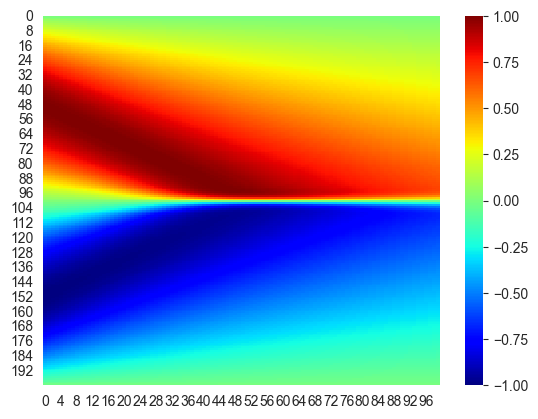

In [12]:
sns.heatmap(y_pred, cmap='jet')

Text(0.5, 1.0, 't=99')

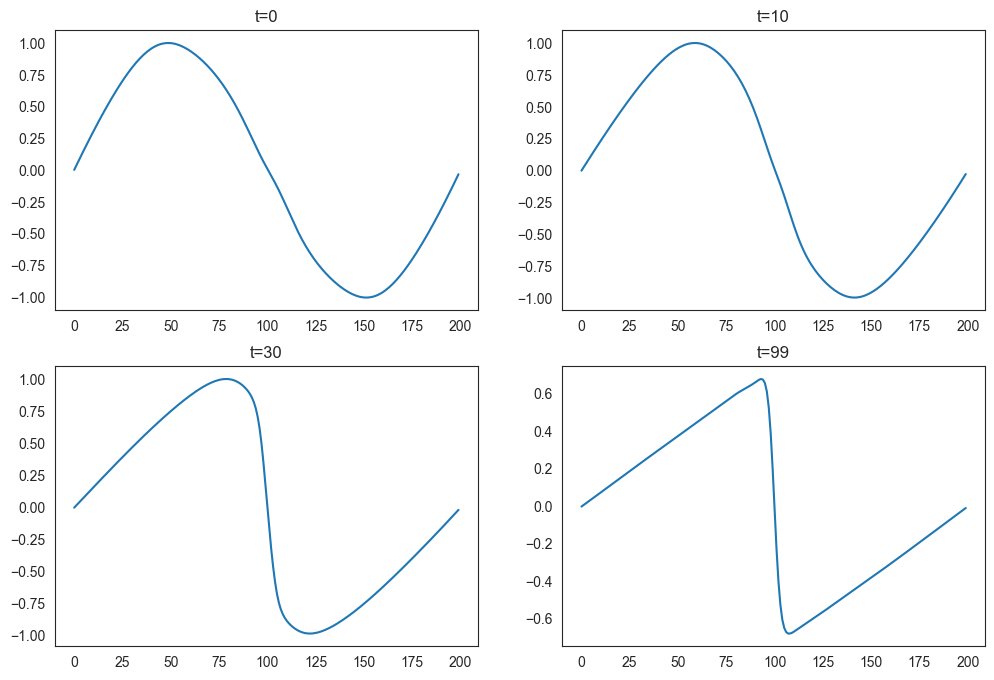

In [13]:
plt.figure(figsize=(12, 8))

plt.subplot(2,2,1)
plt.plot(y_pred[:,0])
plt.title('t=0')

plt.subplot(2,2,2)
plt.plot(y_pred[:,10])
plt.title('t=10')

plt.subplot(2,2,3)
plt.plot(y_pred[:,30])
plt.title('t=30')

plt.subplot(2,2,4)
plt.plot(y_pred[:,99])
plt.title('t=99')